In [1]:
using Oceananigans
using CairoMakie
using JLD2
using Statistics

[ Info: Oceananigans will use 4 threads


In [16]:
foldername = "../../scratch/filament-instability/Ri010-3d"
filename = "3d_state.jld2"
paramfilename = "parameters.jld2"
sp = jldopen("$foldername/$paramfilename") do file
    file["parameters/simulation"]
end
frames, grid = jldopen("$foldername/$filename") do file
    (keys(file["timeseries/t"])[1:end], file["serialized/grid"])
end
ts = jldopen("$foldername/$filename") do file
    [file["timeseries/t/$frame"] for frame in frames] .- 1
end
xᶜᵃᵃ = xnodes(Center, grid)
xᶠᵃᵃ = xnodes(Face, grid)
yᵃᶜᵃ = ynodes(Center, grid)
yᵃᶠᵃ = ynodes(Face, grid)
zᵃᵃᶜ = znodes(Center, grid)
zᵃᵃᶠ = znodes(Face, grid)
Δzᵃᵃᶜ = reshape(diff(zᵃᵃᶠ), 1, 1, length(zᵃᵃᶜ))
Δx = xᶠᵃᵃ[2] - xᶠᵃᵃ[1]
Δy = yᵃᶠᵃ[2] - yᵃᶠᵃ[1]

@inline function dx(fᶜᵃᵃ)
    return (circshift(fᶜᵃᵃ, (-1, 0, 0)) - circshift(fᶜᵃᵃ, (1, 0, 0))) / (2Δx)
end
@inline function dy(fᵃᶜᵃ)
    return (circshift(fᵃᶜᵃ, (0, -1, 0)) - circshift(fᵃᶜᵃ, (0, -1, 0))) / (2Δy)
end
@inline function dz(fᵃᵃᶜ)
    let a = (circshift(fᵃᵃᶜ, (0, 0, -1)) - circshift(fᵃᵃᶜ, (0, 0, 1))) ./ (2Δzᵃᵃᶜ)
        a[:, :, 1] .= 0
        a[:, :, end] .= 0
        a
    end
end

dz (generic function with 1 method)

In [34]:
t = 10
i = argmin(abs.(ts .- t))
frame = frames[i]

"7854"

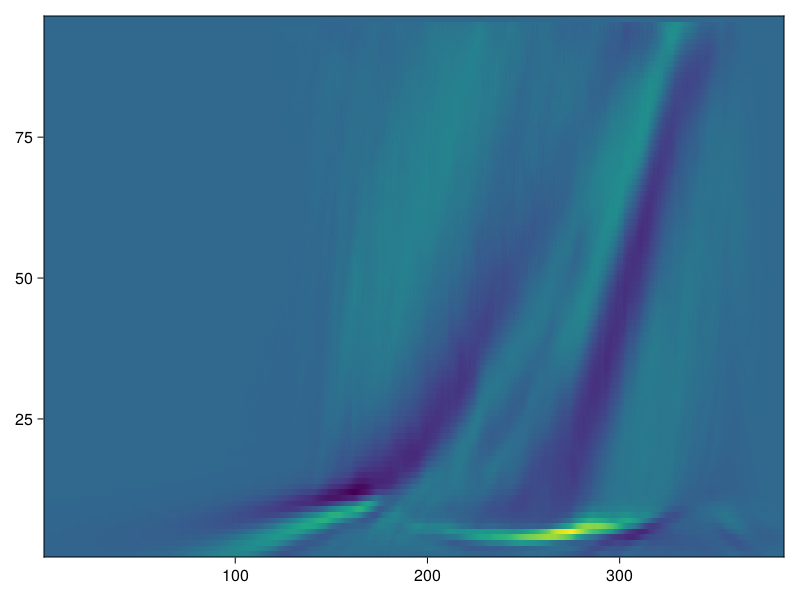

In [35]:
ω = jldopen("$foldername/$filename") do file
    u = file["timeseries/u/$frame"]
    u = (circshift(u, (-1, 0, 0)) .+ circshift(u, (1, 0, 0))) / 2
    w = file["timeseries/w/$frame"]
    w = (w[:, :, 1:end-1] .+ w[:, :, 2:end]) / 2
    ω = dz(u) - dx(w)
    ω[128:512, :, 33:end]
    end;
heatmap(mean(ω; dims=2)[:, 1, :])

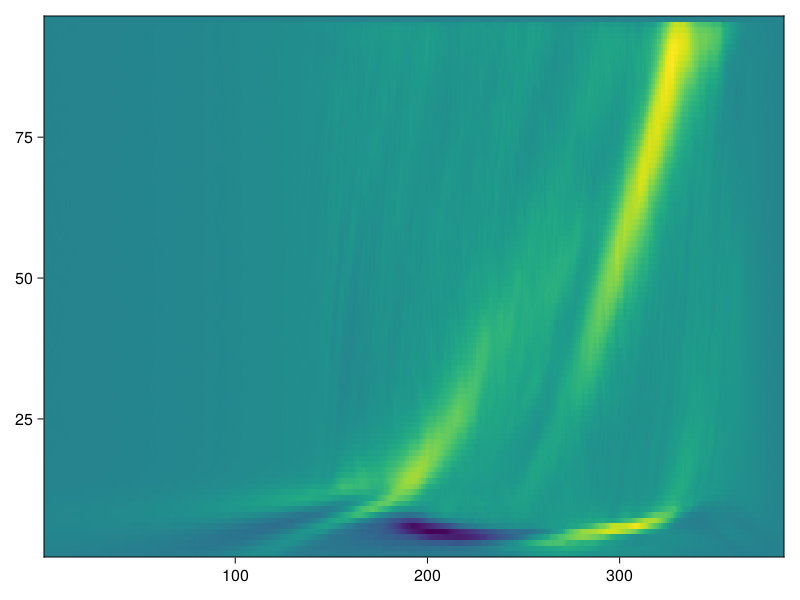

In [36]:
η = jldopen("$foldername/$filename") do file
    v = file["timeseries/v/$frame"]
    v = (circshift(v, (0, -1, 0)) .+ circshift(v, (0, 1, 0))) / 2
    w = file["timeseries/w/$frame"]
    w = (w[:, :, 1:end-1] .+ w[:, :, 2:end]) / 2
    η = dy(w) - dz(v)
    η[128:512, :, 33:end]
    end;
heatmap(mean(η; dims=2)[:, 1, :])

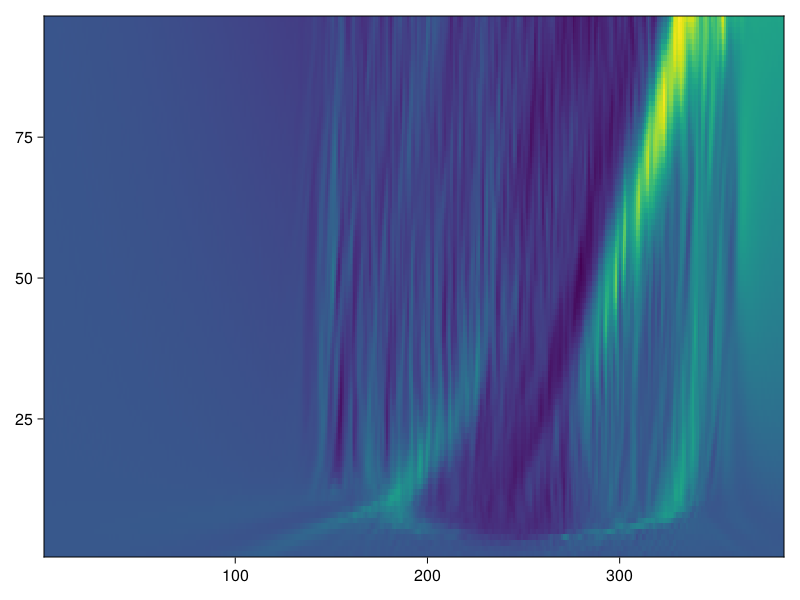

In [37]:
ζ = jldopen("$foldername/$filename") do file
    u = file["timeseries/u/$frame"]
    u = (circshift(u, (-1, 0, 0)) .+ circshift(u, (1, 0, 0))) / 2
    v = file["timeseries/v/$frame"]
    v = (circshift(v, (0, -1, 0)) .+ circshift(v, (0, 1, 0))) / 2
    ζ = dx(v) - dy(u)
    ζ[128:512, :, 33:end]
    end;
heatmap(mean(ζ; dims=2)[:, 1, :])

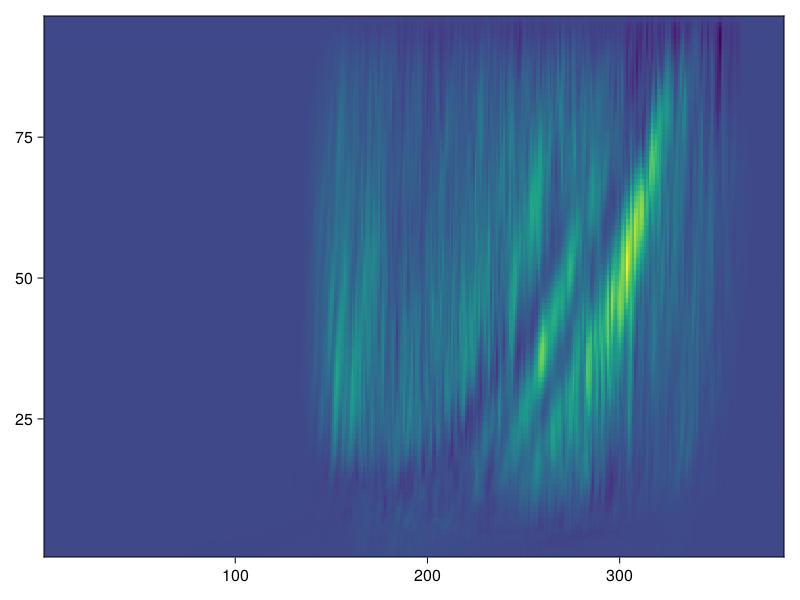

In [38]:
v′w′ = jldopen("$foldername/$filename") do file
    v = file["timeseries/v/$frame"]
    v = (circshift(v, (0, -1, 0)) .+ circshift(v, (0, 1, 0))) / 2
    w = file["timeseries/w/$frame"]
    w = (w[:, :, 1:end-1] .+ w[:, :, 2:end]) / 2
    
    v′ = v .- mean(w; dims=2)
    w′ = w .- mean(w; dims=2)
    
    v′w′ = v′ .* w′
    v′w′[128:512, :, 33:end]
    end;
heatmap(mean(v′w′; dims=2)[:, 1, :])

In [39]:
jldopen("../3D-Ri010-$frame.jld2", "a+") do file
    file["ω"] = ω
    file["η"] = η
    file["ζ"] = ζ
    file["v′w′"] = v′w′
    file["xs"] = xᶜᵃᵃ[128:512]
    file["ys"] = ynodes(Center, grid)
    file["zs"] = zᵃᵃᶜ[33:end]
    file["t"] = t
    end;

In [73]:
b_xz = zeros(length(frames), length(xᶜᵃᵃ), length(zᵃᵃᶜ))
b_xy = zeros(length(frames), length(xᶜᵃᵃ), length(yᵃᶜᵃ))
b_yz = zeros(length(frames), length(yᵃᶜᵃ), length(zᵃᵃᶜ))
for (i, frame) in enumerate(frames)
    jldopen("$foldername/$filename") do file
        b = file["timeseries/v/$frame"]
        b = (circshift(b, (0, -1, 0)) .+ circshift(b, (0, 1, 0))) / 2
        b_xz[i, :, :] .= b[:, 1, :]
        b_xy[i, :, :] .= b[:, :, end]
        b_yz[i, :, :] .= b[end, :, :]
    end
end
jldopen("../volume_video.jld2", "a+") do file
    file["v_xz"] = b_xz
    file["v_xy"] = b_xy
    file["v_yz"] = b_yz
    end;

(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 128)(1024, 1024, 1